In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Project imports
import explore
from wrangle import get_data, cleaned, summarize, target_split, split
from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#alpha for hypothesis tests
alpha = 0.5

# Executive Summary
- Purpose: Analyze Texas motorcycle accidents between 2011 and 2021.
- Goal: Determine high accident areas throughout the state that ended in fatalities. 
- Key Takeaways:
    - Death rate decreases through 2025, with a slight increase beginning 2026.
    - 8293 rows and 11 columns.
    - Average age of riders involved in an accident are 39 years old.
    - Majority of riders who died are in the age range of 40 - 50 years old.
    - Riders not wearing a helmet are likely to survive a motorcycle accident.
    - Seems more older females die in accidents over 40. Where males make up a larger portion of all rider ages.
    - Although the train dataset did better then the baseling in the Rnadon Forrest model both validate and test datasets did not do so well.
- Goals not attained in this analysis that I would have liked to do.
    - Predict the number of fatal accidenets within the next two years.

### Tableau
- Less than two deaths per year predicted through 2025, increasing to two deaths per year after 2026.
- Motorcycle Deaths in Texas between 2011-2021.
- Highest fatality areas:
    1. Dallas 
    2. Houston
    3. San Antonio
    4. Austin
    5. El Paso
- Deaths by Age: Average age is 38. Highest numbers of fatalities by age is 58.
- Death by Hour: Highest death rates at 0200 and 2100 hours.

In [2]:
%%HTML
<div class='tableauPlaceholder' id='viz1634145058280' style='position: relative'><noscript>
<a href='#'>
<img alt='TXMC ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TexasMotorcycleDeaths2011-2021&#47;TXMC&#47;1_rss.png' style='border: none' />
</a>
</noscript>
<object class='tableauViz'  style='display:none;'>
<param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' />
<param name='embed_code_version' value='3' />
<param name='path' value='views&#47;TexasMotorcycleDeaths2011-2021&#47;TXMC?:language=en-US&amp;:embed=true' />
<param name='toolbar' value='yes' />
<param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Te&#47;TexasMotorcycleDeaths2011-2021&#47;TXMC&#47;1.png' />
<param name='animate_transition' value='yes' />
<param name='display_static_image' value='yes' />
<param name='display_spinner' value='yes' />
<param name='display_overlay' value='yes' />
<param name='display_count' value='yes' />
<param name='language' value='en-US' /></object>
</div>
<script type='text/javascript'>
var divElement = document.getElementById('viz1634145058280');
var vizElement = divElement.getElementsByTagName('object')[0];
if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='1050px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';}
else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='1050px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';}
else { vizElement.style.width='100%';vizElement.style.height='977px';}
var scriptElement = document.createElement('script');
scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';
vizElement.parentNode.insertBefore(scriptElement, vizElement);
</script>

### Plan
- Acquire and prepare Texas motorcycle fatalities. Data acquired from Texas Crash Information Record System <a href="https://cris.dot.state.tx.us/public/Query/app/home">(C.R.I.S Query)</a>.
- Analysis based on Classification modeling and ran through the data pipeline.
- A copy of the cleaned dataset is available below.

# Acquire

In [3]:
df = get_data()
df.head(2)

,Crash ID,Average Daily Traffic Amount,Average Daily Traffic Year,City,County,Crash Date,Crash Death Count,Crash Month,Crash Severity,Crash Time,...,Person Blood Alcohol Content Test Result,Person Death Count,Person Drug Test Result,Person Ethnicity,Person Gender,Person Helmet,Person Injury Severity,Person Not Injured Count,Person Total Injury Count,Person Type
0,11825679,21549,2018,SAN ANTONIO,BEXAR,1/1/11,0,1,B - SUSPECTED MINOR INJURY,2230,...,No Data,0,97 - NOT APPLICABLE,H - HISPANIC,1 - MALE,1 - NOT WORN,B - SUSPECTED MINOR INJURY,0,1,5 - DRIVER OF MOTORCYCLE TYPE VEHICLE
1,11825679,21549,2018,SAN ANTONIO,BEXAR,1/1/11,0,1,B - SUSPECTED MINOR INJURY,2230,...,No Data,0,No Data,H - HISPANIC,2 - FEMALE,1 - NOT WORN,C - POSSIBLE INJURY,0,1,6 - PASSENGER/OCCUPANT ON MOTORCYCLE TYPE VEHICLE


In [4]:
summarize(df)

(9055, 39)
___________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   Crash ID                                  9055 non-null   int64 
 1   Average Daily Traffic Amount              9055 non-null   object
 2   Average Daily Traffic Year                9055 non-null   object
 3   City                                      9055 non-null   object
 4   County                                    9055 non-null   object
 5   Crash Date                                9055 non-null   object
 6   Crash Death Count                         9055 non-null   int64 
 7   Crash Month                               9055 non-null   int64 
 8   Crash Severity                            9055 non-null   object
 9   Crash Time                                9055 non-null   int64 
 10  Crash Tot

##### Key Takeaways
- Began with 9055 columns and 39 rows.
- Convert datatypes as needed.
- Combine date and time columns. Set date index.
- Drop unnecessary columns.
- Rename columns.
- Encode columns.
- Although there are no nulls I did have to clean up 'UNKNOWN and No Data' values.

# Prepared

In [5]:
df = cleaned(df)
df.head()

,city,county,deceased,injured,day,latitude,longitude,age,driver,helmet,male
crash_date,,,,,,,,,,,
2011-01-01 22:30:00,SAN ANTONIO,BEXAR,0,1,SATURDAY,29.358915,-98.566314,27,1,0,1
2011-01-01 22:30:00,SAN ANTONIO,BEXAR,0,1,SATURDAY,29.358915,-98.566314,28,0,0,0
2011-01-03 12:15:00,SAN ANTONIO,BEXAR,1,0,MONDAY,29.537465,-98.424572,53,1,0,1
2011-01-05 21:15:00,SAN ANTONIO,BEXAR,0,1,WEDNESDAY,29.513015,-98.535152,47,1,0,1
2011-01-06 12:10:00,AUSTIN,WILLIAMSON,0,1,THURSDAY,30.476422,-97.764810,19,1,1,1


- Change to code from markdown and paste your own filepath below.
- df.to_csv('/your file path here/txmc.csv')

In [6]:
summarize(df)

(8293, 11)
___________________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8293 entries, 2011-01-01 22:30:00 to 2021-10-06 00:40:00
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   city       8293 non-null   object 
 1   county     8293 non-null   object 
 2   deceased   8293 non-null   int64  
 3   injured    8293 non-null   int64  
 4   day        8293 non-null   object 
 5   latitude   8293 non-null   float64
 6   longitude  8293 non-null   float64
 7   age        8293 non-null   int64  
 8   driver     8293 non-null   int64  
 9   helmet     8293 non-null   int64  
 10  male       8293 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 777.5+ KB
None
___________________________
city         0
county       0
deceased     0
injured      0
day          0
latitude     0
longitude    0
age          0
driver       0
helmet       0
male         0
dtype: int64


##### Key Takeaways
- Down to 8293 rows and 11 columns.
- Encoded male, helmet, driver, deceased and injured columns.
- Dropped 726 latitude rows that had no values.
- Concated date and time, converted to datetime and set it as the index.
- Filled age 'No Data' with average age.
- Data types converted as necessary.
- A lot of background data prep was done an annotated in the 'cleaned' function in the wrangle.py.

# Explore

- Expoloration was done on the train dataset using Univariate, Bivariate and Multivariate stats.

### Split
- Data set split into train, validate, and test with 'deceased ' as the target.

In [7]:
#initial hypothesis test and model was done on this split.
train, validate, test = target_split(df, 'deceased', seed=123)

# Univariate

In [8]:
#set categorical and quantitative variables with the appropriate features.
cat_vars = ['injured', 'driver', 'helmet', 'male']
quant_vars = ['age']

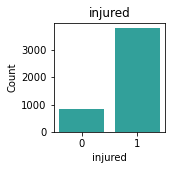

   injured  Count  Percent
1        1   3797    81.78
0        0    846    18.22
_________________________________________________________________


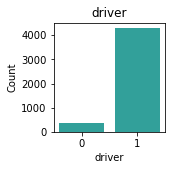

   driver  Count  Percent
1       1   4293    92.46
0       0    350     7.54
_________________________________________________________________


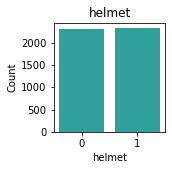

   helmet  Count  Percent
0       1   2326     50.1
1       0   2317     49.9
_________________________________________________________________


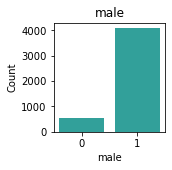

   male  Count  Percent
1     1   4087    88.02
0     0    556    11.98
_________________________________________________________________


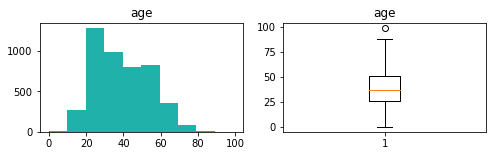

count    4643.000000
mean       39.007323
std        14.746937
min         0.000000
25%        26.000000
50%        37.000000
75%        51.000000
max        99.000000
Name: age, dtype: float64


In [9]:
explore.explore_univariate(train, cat_vars, quant_vars)

##### Key Takeaways
1. 81.2% riders involved in a motorcycle accident are injured.
2. 92.5% riders involved in a motorcycle accident are the drivers.
3. About half of riders involved in a motorcylce accident where a helmet.
4. 88% are male riders.
5. Average age of riders involved in an accident are 39 years old.

## Bivariate

injured 
_____________________

         chi2       p-value  degrees of freedom
0  353.864798  6.102925e-79                   1

observed:
 deceased     0    1   All
injured                  
0          712  134   846
1         3739   58  3797
All       4451  192  4643

expected:
              0           1
0   811.015723   34.984277
1  3639.984277  157.015723


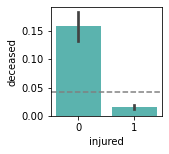


_____________________

driver 
_____________________

       chi2   p-value  degrees of freedom
0  5.021939  0.025028                   1

observed:
 deceased     0    1   All
driver                   
0          327   23   350
1         4124  169  4293
All       4451  192  4643

expected:
              0           1
0   335.526599   14.473401
1  4115.473401  177.526599


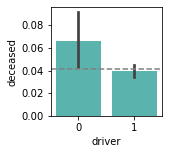


_____________________

helmet 
_____________________

       chi2   p-value  degrees of freedom
0  9.872517  0.001678                   1

observed:
 deceased     0    1   All
helmet                   
0         2208  118  2326
1         2243   74  2317
All       4451  192  4643

expected:
              0          1
0  2229.813913  96.186087
1  2221.186087  95.813913


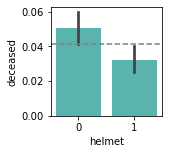


_____________________

male 
_____________________

       chi2   p-value  degrees of freedom
0  0.012478  0.911058                   1

observed:
 deceased     0    1   All
male                     
0          534   22   556
1         3917  170  4087
All       4451  192  4643

expected:
              0           1
0   533.007969   22.992031
1  3917.992031  169.007969


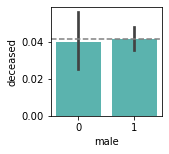


_____________________

age 
____________________



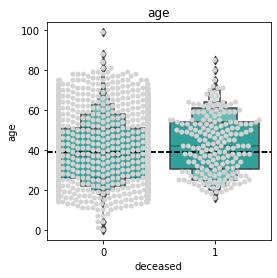

           count       mean        std   min    25%   50%   75%   max
deceased                                                             
0         4451.0  38.829252  14.724452   0.0  26.00  37.0  51.0  99.0
1          192.0  43.135417  14.703079  16.0  30.75  42.0  54.0  85.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=355728.0, pvalue=8.27016944416783e-05)

____________________



In [10]:
explore.explore_bivariate(train, 'deceased', cat_vars, quant_vars)

##### Key Takeaways
1. Of those riders injured in the accident 58 died (train dataset).
2. Drivers account for 169 deaths and passangers account for 23.
3. 118 riders who died 118 were NOT wearing a helmet.
4. Riders who died are almost equal in gender.
5. Majority of riders who died are in the age range of 40 - 50 years old.

## Hypothesis and Testing

##### 1. How likely is a rider to survive a motorcycle accident not wearing a helmet? (chi2)
    - Null: Its not likely a rider will survive a motorcycle accident if not wearing a helmet.
    - Alternate: It is likely the rider will survive a motorcycle accident if not wearing a helmet.

In [11]:
Null = 'Its not likely a rider will survive a motorcycle accident if not wearing a helmet.'
Alternate = 'It is likely the rider will survive a motorcycle accident if not wearing a helmet.'

observed = pd.crosstab(train.deceased, train.helmet)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 9.8725
p     = 0.0017


We reject the null and accept the alternate: It is likely the rider will survive a motorcycle accident if not wearing a helmet.


##### 2. Are people over 40 more likely to die in a motorcycle accident? (ttest 1samp)
    - Null: People over 40 are NOT more likely to die in a motorcycle accident.
    - Alternate: People over 40 are more likely to die in a motorcycle accident.

In [12]:
Null = 'People over 40 are NOT more likely to die in a motorcycle accident.'
Alternate = 'People over 40 are more likely to die in a motorcycle accident.'

older = train[train.age > 40].deceased
younger = train.deceased.mean()
test_results = stats.ttest_1samp(older, younger)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 9.8725
p     = 0.0017


We reject the null and accept the alternate: People over 40 are more likely to die in a motorcycle accident.


##### 2. Rider with a passenger who is more likely to die in a motorcycle accident; passenger or driver?(ttest 2samp)
    - Null: Passengers are more likely to die in a motorcycle accident.
    - Alternate: Driver are more likely to die in a motorcycle accident.

In [13]:
Null = 'Passengers are more likely to die in a motorcycle accident.'
Alternate = 'Drivers are more likely to die in a motorcycle accident.'

driver = train[train['driver'] == 1]
passenger = train[train['driver'] == 0]
test_results = stats.ttest_ind(driver.deceased, passenger.deceased)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 9.8725
p     = 0.0017


We reject the null and accept the alternate: Drivers are more likely to die in a motorcycle accident.


##### Key Takeaway
1. Riders not wearing a helmet are likely to survive a motorcycle accident.
    - This tells me motorcycle accidents may not be severe enough to cause a fatal casualty. Good news, I guess, for riders - atleast for those in Texas!
3. Riders older than 40 are more likely to die in a motorcycle accident. 
    - Intersting my initial thoughts would be younger riders would be invovlved in more fatal causualties with their inexperience.
    - However; for older riders, this could mean several things: too comfortable, over confident, less reactive, and no recent safety training/riderskills.
4. Drivers are more then likely to die in when riding with a passenger.
    - Makes me wonder if the drive's death is compounded by the force of the passenger.
    - On the other hand is the driver acting as a buffer for the passenger and not taking the full brunt of the accident.
    - What I don't know is if the motorcycle was hit head on, by either side or rear ended.

## Multivariate

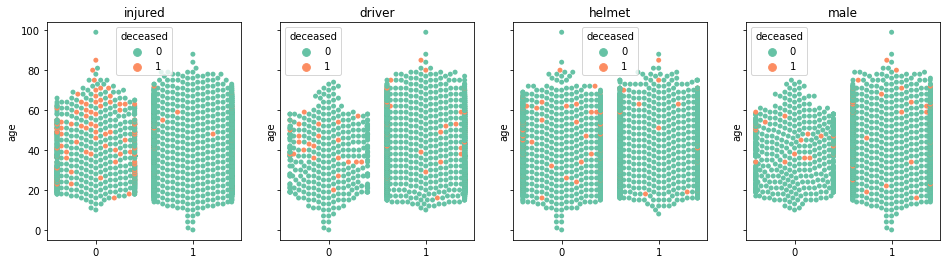

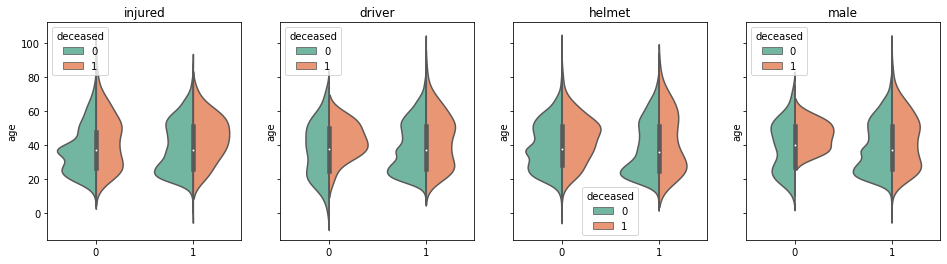

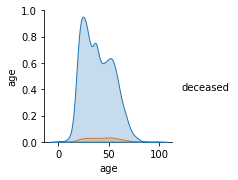

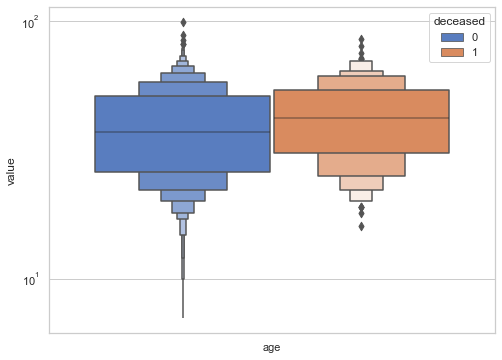

In [14]:
explore.explore_multivariate(train, 'deceased', cat_vars, quant_vars)

##### Key Takeaway
1. Violin plot confirms age is a factor in those riders who get in more accidents that conclude in injuy or death.
2. Although you are likely to survive when not wearing a helmet the violin plot show riders 40 yrs. and older who do not wear a helment result in a fatal casualty.
3. Seems more older females die in accidents over 40. Where males make up a larger portion of all rider ages.
4. Boxplot shows a slightly higher fatality average than injuries.

## Train, Validate, Test

In [15]:
#setup x,y split variables
X_train = train[['driver', 'helmet', 'age', 'injured']]
y_train = train.deceased
X_validate = validate[['driver', 'helmet', 'age', 'injured']]
y_validate = validate.deceased
X_test = test[['driver', 'helmet', 'age', 'injured']]
y_test = test.deceased

In [16]:
#print of x, y variables shape.
print(X_train.shape,y_train.shape)
print(X_validate.shape,y_validate.shape)
print(X_test.shape,y_test.shape)

(4643, 4) (4643,)
(1991, 4) (1991,)
(1659, 4) (1659,)


# Modeling
- Predict fatality in a motorcycle accident.

## Baseline

In [17]:
baseline = y_train.mode()
matches_baseline_prediction = y_train == 0
baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.96


### Decision Tree

In [18]:
#Create the model
dt = DecisionTreeClassifier(max_depth=5, random_state=123)
#Fit the model
dt.fit(X_train, y_train)
#Use the model
dt.predict(X_train)
#prediction, accuracy, & class report evaluations
explore.get_metrics_bin(dt, X_train, y_train)


    The accuracy for our model is 0.9593
    The True Positive Rate is 0.026, The False Positive Rate is 0.000449,
    The True Negative Rate is 1.0, and the False Negative Rate is 0.974
    


,precision,recall,f1-score,support
0,0.959664,0.999551,0.979201,4451.000000
1,0.714286,0.026042,0.050251,192.000000
accuracy,0.959294,0.959294,0.959294,0.959294
macro avg,0.836975,0.512796,0.514726,4643.000000
weighted avg,0.949516,0.959294,0.940787,4643.000000


## Random Forrest

In [19]:
#Create the Model
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=1, n_estimators=100,
max_depth=10, random_state=123)
#Fit the Model
rf.fit(X_train, y_train)
#Use the Model
y_pred = rf.predict(X_train)
#prediction, accuracy, & class report evaluations
explore.get_metrics_bin(rf, X_train, y_train)


    The accuracy for our model is 0.9623
    The True Positive Rate is 0.115, The False Positive Rate is 0.00112,
    The True Negative Rate is 0.999, and the False Negative Rate is 0.885
    


,precision,recall,f1-score,support
0,0.963172,0.998877,0.980699,4451.000000
1,0.814815,0.114583,0.200913,192.000000
accuracy,0.962309,0.962309,0.962309,0.962309
macro avg,0.888993,0.556730,0.590806,4643.000000
weighted avg,0.957037,0.962309,0.948453,4643.000000


## KNN

In [20]:
#Create the model
knn = KNeighborsClassifier(n_neighbors=7, weights='uniform')
#Fit the model
knn.fit(X_train, y_train)
#Use the model
y_pred = knn.predict(X_train)
#prediction, accuracy, & class report evaluations
explore.get_metrics_bin(knn, X_train, y_train)


    The accuracy for our model is 0.9586
    The True Positive Rate is 0.0365, The False Positive Rate is 0.00157,
    The True Negative Rate is 0.998, and the False Negative Rate is 0.964
    


,precision,recall,f1-score,support
0,0.960035,0.998427,0.978855,4451.000000
1,0.500000,0.036458,0.067961,192.000000
accuracy,0.958647,0.958647,0.958647,0.958647
macro avg,0.730017,0.517443,0.523408,4643.000000
weighted avg,0.941011,0.958647,0.941187,4643.000000


## LogRegression

In [21]:
#Create the model
log_reg = LogisticRegression(C=1, random_state=123, intercept_scaling=1, solver='lbfgs')
#Fit the model
log_reg.fit(X_train, y_train)
#Use the model
y_pred = log_reg.predict(X_train)
#prediction, accuracy, & class report evaluations
explore.get_metrics_bin(log_reg, X_train, y_train)


    The accuracy for our model is 0.9586
    The True Positive Rate is 0.0, The False Positive Rate is 0.0,
    The True Negative Rate is 1.0, and the False Negative Rate is 1.0
    


,precision,recall,f1-score,support
0,0.958647,1.000000,0.978887,4451.000000
1,0.000000,0.000000,0.000000,192.000000
accuracy,0.958647,0.958647,0.958647,0.958647
macro avg,0.479324,0.500000,0.489444,4643.000000
weighted avg,0.919005,0.958647,0.938408,4643.000000


## Validate: Random Forrest

In [22]:
explore.get_metrics_bin(rf, X_validate, y_validate)


    The accuracy for our model is 0.9538
    The True Positive Rate is 0.0488, The False Positive Rate is 0.00733,
    The True Negative Rate is 0.993, and the False Negative Rate is 0.951
    


,precision,recall,f1-score,support
0,0.960466,0.992666,0.976301,1909.000000
1,0.222222,0.048780,0.080000,82.000000
accuracy,0.953792,0.953792,0.953792,0.953792
macro avg,0.591344,0.520723,0.528150,1991.000000
weighted avg,0.930061,0.953792,0.939386,1991.000000


## Test: Random Forrest

In [23]:
explore.get_metrics_bin(rf, X_test, y_test)


    The accuracy for our model is 0.953
    The True Positive Rate is 0.0435, The False Positive Rate is 0.00755,
    The True Negative Rate is 0.992, and the False Negative Rate is 0.957
    


,precision,recall,f1-score,support
0,0.959854,0.992453,0.975881,1590.000000
1,0.200000,0.043478,0.071429,69.000000
accuracy,0.952984,0.952984,0.952984,0.952984
macro avg,0.579927,0.517966,0.523655,1659.000000
weighted avg,0.928251,0.952984,0.938264,1659.000000


##### Key Takeaways
1. Random Forrest performed the best out of the models tested.
2. Both validate and test data sets performed slightly less then the baseline.
3. More likely to survive, but just barely.

# Conclusion

- Deaths decrease into 2025 and slightly increase into and through 2026.
- Highest fatality areas in Texas:
    1. Dallas 
    2. Houston
    3. San Antonio
    4. Austin
    5. El Paso
- Deaths by Age: Average age is 39. Highest numbers of fatalities by age is 58.
- Death by Hour: Highest death rates at 0200 and 2100 hours.
- Average age of riders involved in an accident are 38 years old.
- Majority of riders who died are in the age range of 40 - 50 years old.
- Riders not wearing a helmet are likely to survive a motorcycle accident.
- Seems more older females die in accidents over 40. Where males make up a larger portion of all rider ages.
- Future considerations:
    - Severity of accident given speed, crash distance, weather, surface, and impact.
    - Why is it riders over 40 are prone to more fatalities then younger riders?
    - Of those rides who do die, it is interesting that the fatality rate among femal and male riders is just about the same.